# **1. Dataset Overview**

The dataset used in this project is sourced from the [Rice Leaf Diseases Detection dataset](https://www.kaggle.com/datasets/loki4514/rice-leaf-diseases-detection/data) available on Kaggle. It contains images of rice plant leaves categorized by various disease conditions, including healthy leaves. Each category is organized into a separate folder.

To localize the project and enhance usability for Indonesian users, the original labels were translated into Bahasa Indonesia. The categories included in the dataset are as follows:

- Sehat (Healthy Rice Leaf): 1085 Images  
- Bercak Cokelat (Brown Spot): 1546 Images  
- Bercak Cokelat Sempit Daun (Narrow Brown Leaf Spot): 954 Images
- Blas Daun (Leaf Blast): 1748 Images
- Busuk Leher Malai (Neck Blast): 1000 Images
- Hawar Daun Bakteri (Bacterial Leaf Blight): 1197 Images
- Hawar Pelepah (Sheath Blight): 1629 Images
- Hispa (Rice Hispa): 1299 Images
- Luka Bakar Daun (Leaf Scald): 1332 Images

This dataset provides a solid foundation for building and training deep learning models to detect and classify rice leaf diseases through image-based analysis.

# **2. Library Import**

This project uses the following libraries:

- `numpy`, `os`, `random`: Basic operations, file handling, and randomness.
- `matplotlib`: For displaying images and plotting accuracy/loss curves.
- `tensorflow.keras.preprocessing.image`: Loads and augments image data.
- `tensorflow.keras.applications`: Provides pretrained models like MobileNetV2 and Xception.
- `tensorflow.keras.models` and `layers`: For building and customizing neural network models.
- `regularizers`, `optimizers`, `callbacks`: Used to compile models and control training.
- `sklearn.metrics`: For confusion matrix and classification report.
- `time`: Tracks training duration in custom callbacks.

In [ ]:
# !pip install tensorflow

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing import image

# **3. Data Loading**

After mounting Google Drive and specifying the dataset path, we list all available class folders to identify the categories of rice leaf conditions. Each folder represents a unique class such as "Hawar Pelepah" (Sheath Blight), "Hispa" (Rice Hispa), or "Sehat" (Healthy Rice Leaf).

To verify dataset integrity and understand the visual characteristics of each class, we randomly display a few sample images per category. This step ensures that the folder structure is correct and that the images are loaded successfully before proceeding with model training.

All images are resized to 224×224 pixels to match the input shape required by the deep learning models.

In [ ]:
dataset_path = "/content/drive/MyDrive/Capstone/Padi"

class_names = os.listdir(dataset_path)
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(dataset_path, cls))]
print("Daftar Kelas:", class_names)

Daftar Kelas: ['Hawar Pelepah', 'Hispa', 'Busuk Leher Malai', 'Bercak Cokelat Sempit Daun', 'Luka Bakar Daun', 'Bercak Cokelat', 'Sehat', 'Blas Daun', 'Hawar Daun Bakteri']



Label: Hawar Pelepah


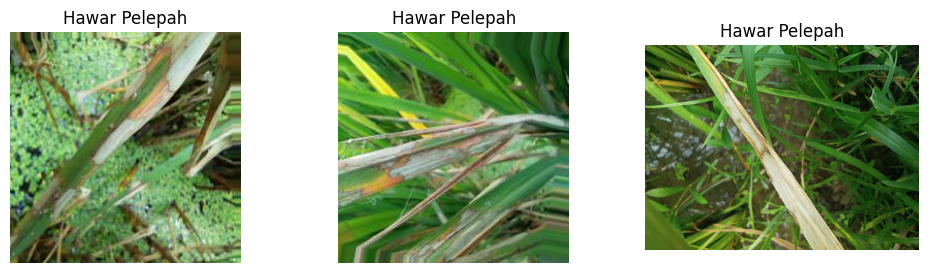


Label: Hispa


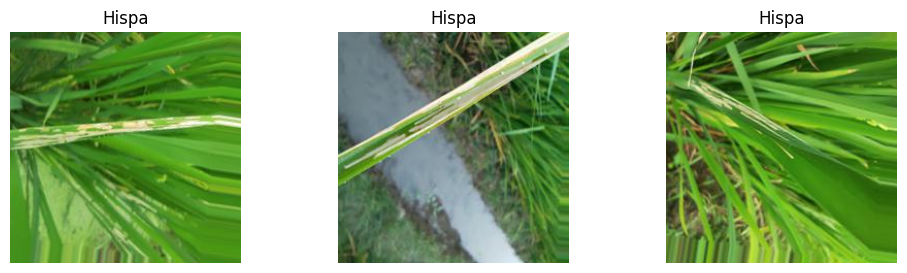


Label: Busuk Leher Malai


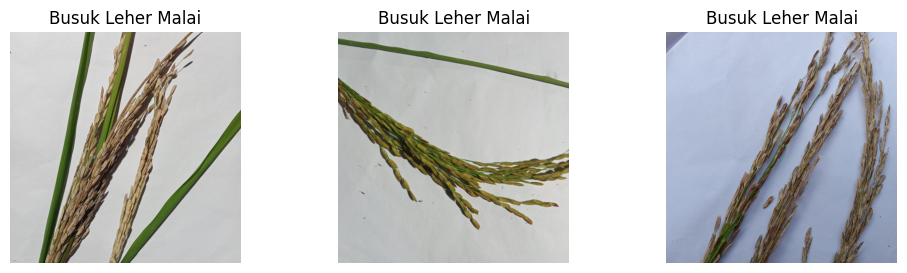


Label: Bercak Cokelat Sempit Daun


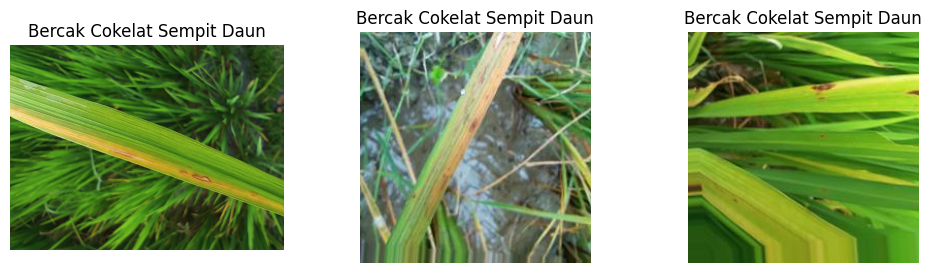


Label: Luka Bakar Daun


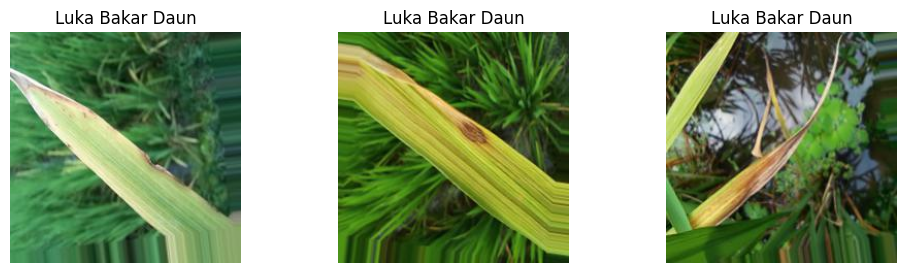


Label: Bercak Cokelat


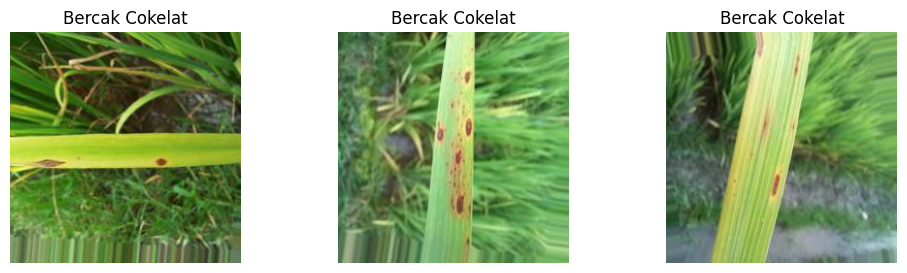


Label: Sehat


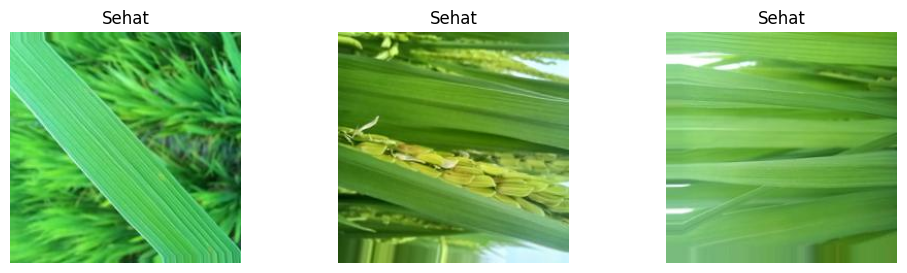


Label: Blas Daun


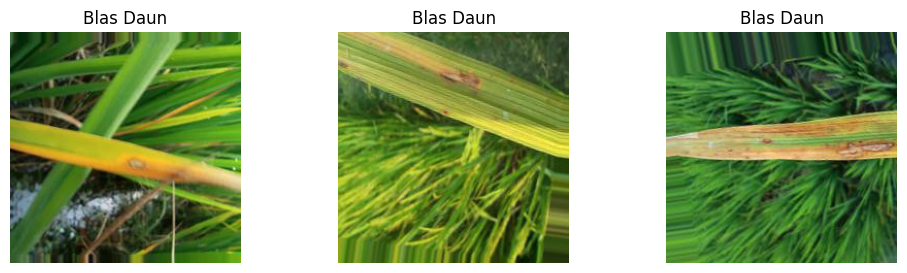


Label: Hawar Daun Bakteri


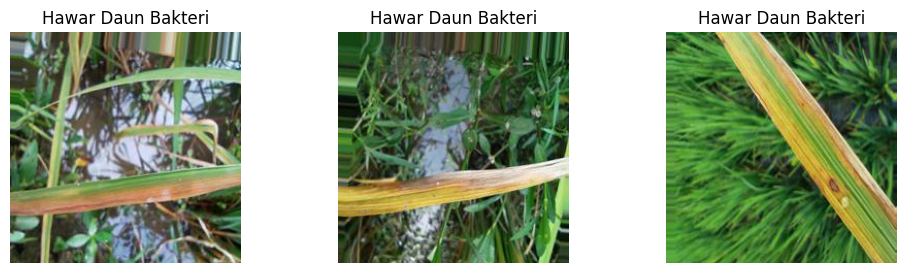

In [ ]:
n_images_per_class = 3
img_size = (224, 224)

for cls in class_names:
    folder = os.path.join(dataset_path, cls)
    images = os.listdir(folder)
    selected_images = random.sample(images, min(n_images_per_class, len(images)))

    print(f"\nLabel: {cls}")
    plt.figure(figsize=(12, 3))
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, n_images_per_class, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
    plt.show()

# **4. Data Preprocessing**

To prepare the image dataset for model training, we use `ImageDataGenerator` for normalization and augmentation. This step ensures the model can generalize better to unseen data.

- All images are rescaled by 1./255 to normalize pixel values between 0 and 1.
- Augmentation techniques such as rotation, zoom, shift, shear, and horizontal flip are applied to the training data.
- The dataset is split into training (80%) and validation (20%) using the `validation_split` argument.
- `flow_from_directory()` automatically loads images from folders and assigns labels based on folder names.
- Each image is resized to 224×224 pixels, and data is batched in size of 32 for efficient training.

A few training images are then visualized to verify that the images are loaded correctly and the class labels are mapped as expected.

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
img_size = (224, 224)
batch_size = 32

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

Found 9444 images belonging to 9 classes.
Found 2356 images belonging to 9 classes.


In [ ]:
print("Mapping label:", train_data.class_indices)

Mapping label: {'Bercak Cokelat': 0, 'Bercak Cokelat Sempit Daun': 1, 'Blas Daun': 2, 'Busuk Leher Malai': 3, 'Hawar Daun Bakteri': 4, 'Hawar Pelepah': 5, 'Hispa': 6, 'Luka Bakar Daun': 7, 'Sehat': 8}


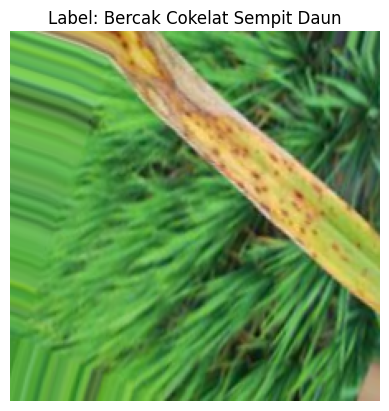

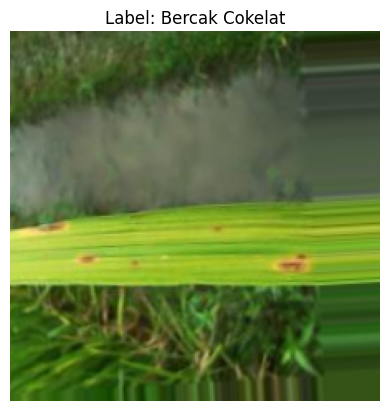

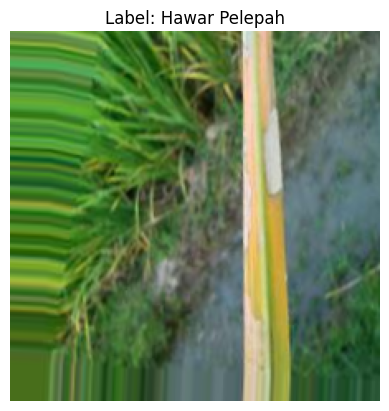

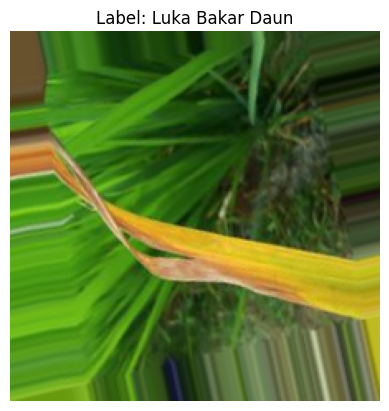

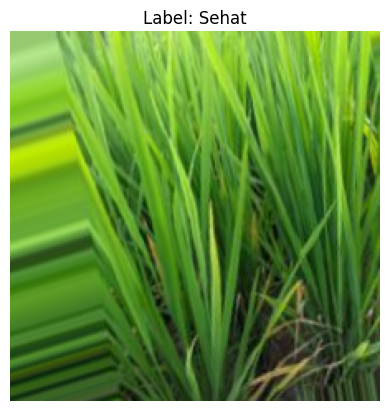

In [ ]:
images, labels = next(train_data)

for i in range(5):
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = list(train_data.class_indices.keys())[label_index]
    plt.title(f"Label: {label_name}")
    plt.axis("off")
    plt.show()

# **5. Training and Evaluation**

## **a. MobileNet**

We use a pretrained MobileNetV2 as the base model with `include_top=False` to remove the original classification head. The last 20 layers are set to be trainable for fine-tuning, while earlier layers remain frozen to retain learned features from ImageNet.

A custom classification head is added on top:
- GlobalAveragePooling2D layer
- Dense layer with ReLU activation and L2 regularization
- Dropout layer to prevent overfitting
- Final Dense layer with softmax for 9 output classes

The model is compiled using:
- Optimizer: Adam (learning rate = 1e-4)
- Loss: categorical crossentropy
- Metric: accuracy

To improve training, we use:
- `EarlyStopping` to stop when validation accuracy stagnates
- `ModelCheckpoint` to save the best model based on validation accuracy
- A custom `TrainingLogger` callback to show per-epoch accuracy change and training time

The model is trained for up to 50 epochs, and training stops early once validation accuracy reaches 95% or no longer improves for 5 epochs.

After training, the model is evaluated using a confusion matrix and classification report. The final model achieved **92% accuracy**, with high precision and recall across all 9 rice leaf disease classes.

In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[:-20]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "mobilenetv2_rice.keras",
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
class TrainingLogger(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.prev_val_acc = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch + 1} dimulai...")

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.epoch_start_time
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")

        if self.prev_val_acc is not None:
            delta = val_acc - self.prev_val_acc
            trend = "🔺" if delta > 0 else "🔻" if delta < 0 else "➡️"
            delta_str = f"{trend} {abs(delta)*100:.2f}%"
        else:
            delta_str = "-"

        self.prev_val_acc = val_acc

        print(f" Epoch {epoch+1} selesai dalam {duration:.2f} detik")
        print(f"  → Training Accuracy: {acc*100:.2f}%")
        print(f"  → Validation Accuracy: {val_acc*100:.2f}% ({delta_str})")

        if val_acc >= 0.95:
            print(f"\n🛑 Training dihentikan otomatis karena akurasi telah mencapai {val_acc*100:.2f}%")
            self.model.stop_training = True

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, TrainingLogger()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1 dimulai...
Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4471 - loss: 1.9917  Epoch 1 selesai dalam 3900.78 detik
  → Training Accuracy: 57.83%
  → Validation Accuracy: 57.17% (-)
296/296 ━━━━━━━━━━━━━━━━━━━━ 3901s 13s/step - accuracy: 0.4475 - loss: 1.9905 - val_accuracy: 0.5717 - val_loss: 1.6738

Epoch 2 dimulai...
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.7537 - loss: 1.1335 Epoch 2 selesai dalam 228.20 detik
  → Training Accuracy: 77.20%
  → Validation Accuracy: 66.09% (🔺 8.91%)
296/296 ━━━━━━━━━━━━━━━━━━━━ 228s 772ms/step - accuracy: 0.7537 - loss: 1.1333 - val_accuracy: 0.6609 - val_loss: 1.3817

Epoch 3 dimulai...
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8238 - loss: 0.9282 Epoch 3 selesai dalam 226.66 detik
  → Training Accuracy: 83.71%
  → Validation Accuracy: 62.90% (🔻 3.18%)
296/296 ━━━━━━━━━━━━━━━━━━━━ 227s 767ms/step - accuracy: 0.8239 - loss: 0.9281 - val_accuracy: 0.6290 - val_loss: 1.5448

In [ ]:
val_data.reset()

y_true = []
y_pred = []

for i in range(len(val_data)):
    X_batch, y_batch = val_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

<Figure size 800x600 with 0 Axes>

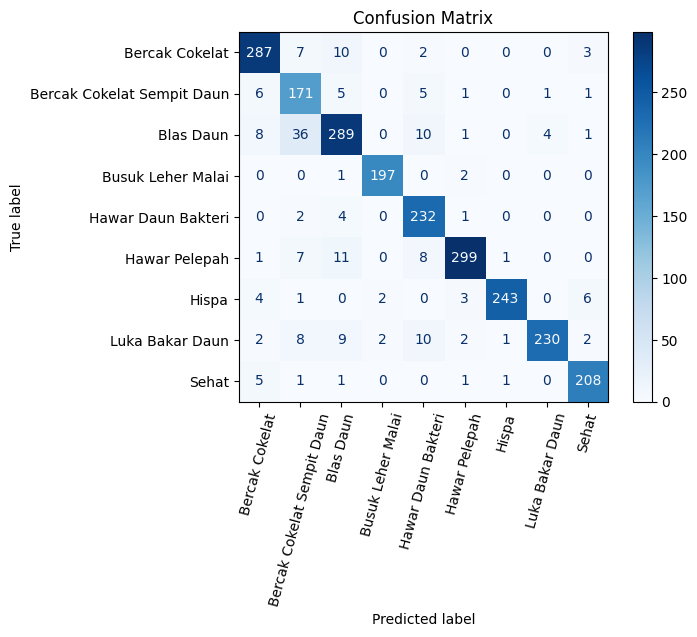

                            precision    recall  f1-score   support

            Bercak Cokelat       0.92      0.93      0.92       309
Bercak Cokelat Sempit Daun       0.73      0.90      0.81       190
                 Blas Daun       0.88      0.83      0.85       349
         Busuk Leher Malai       0.98      0.98      0.98       200
        Hawar Daun Bakteri       0.87      0.97      0.92       239
             Hawar Pelepah       0.96      0.91      0.94       327
                     Hispa       0.99      0.94      0.96       259
           Luka Bakar Daun       0.98      0.86      0.92       266
                     Sehat       0.94      0.96      0.95       217

                  accuracy                           0.92      2356
                 macro avg       0.92      0.92      0.92      2356
              weighted avg       0.92      0.92      0.92      2356



In [ ]:
class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=75)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

## **b. Xception**

We also experimented with the Xception model as an alternative to MobileNetV2. Xception is a deeper architecture that uses depthwise separable convolutions and is known for its strong performance on image classification tasks.

The model was fine-tuned on the rice leaf disease dataset, following the same training strategy:
- The top layers were customized with a GlobalAveragePooling2D layer, followed by a Dense layer with ReLU activation, dropout, and a softmax output layer.
- The model was compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.
- Early stopping and model checkpoint callbacks were applied to monitor validation accuracy and prevent overfitting.

After training, the model achieved **94% validation accuracy**. The evaluation results show strong performance across most classes, with precision and recall scores above 90% for nearly all categories.

The confusion matrix and classification report confirm that Xception performs slightly better than MobileNetV2 on this dataset, especially in classes like **Hispa**, **Hawar Pelepah**, and **Busuk Leher Malai**.

In [ ]:
base_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[:-20]:
    layer.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
checkpoint = ModelCheckpoint(
    "xception_rice.keras",
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, TrainingLogger()]
)


Epoch 1 dimulai...
Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.4751 - loss: 2.3157 Epoch 1 selesai dalam 268.49 detik
  → Training Accuracy: 62.35%
  → Validation Accuracy: 73.51% (-)
296/296 ━━━━━━━━━━━━━━━━━━━━ 268s 839ms/step - accuracy: 0.4756 - loss: 2.3143 - val_accuracy: 0.7351 - val_loss: 1.5246

Epoch 2 dimulai...
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8079 - loss: 1.2854 Epoch 2 selesai dalam 233.40 detik
  → Training Accuracy: 82.41%
  → Validation Accuracy: 79.37% (🔺 5.86%)
296/296 ━━━━━━━━━━━━━━━━━━━━ 233s 788ms/step - accuracy: 0.8079 - loss: 1.2852 - val_accuracy: 0.7937 - val_loss: 1.3068

Epoch 3 dimulai...
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8753 - loss: 1.0259 Epoch 3 selesai dalam 235.26 detik
  → Training Accuracy: 88.63%
  → Validation Accuracy: 85.36% (🔺 5.98%)
296/296 ━━━━━━━━━━━━━━━━━━━━ 235s 794ms/step - accuracy: 0.8754 - loss: 1.0257 - val_accuracy: 0.8536 - val_loss: 1.070

In [ ]:
val_data.reset()

y_true = []
y_pred = []

for i in range(len(val_data)):
    X_batch, y_batch = val_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

<Figure size 800x600 with 0 Axes>

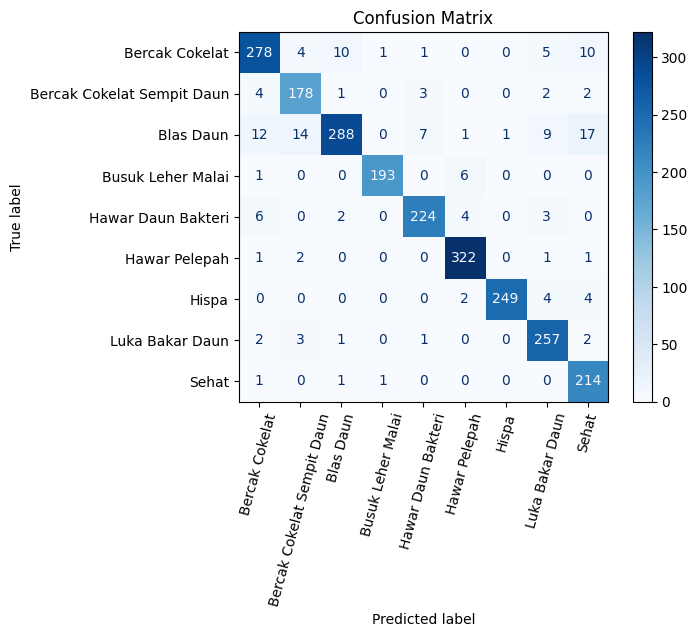

                            precision    recall  f1-score   support

            Bercak Cokelat       0.91      0.90      0.91       309
Bercak Cokelat Sempit Daun       0.89      0.94      0.91       190
                 Blas Daun       0.95      0.83      0.88       349
         Busuk Leher Malai       0.99      0.96      0.98       200
        Hawar Daun Bakteri       0.95      0.94      0.94       239
             Hawar Pelepah       0.96      0.98      0.97       327
                     Hispa       1.00      0.96      0.98       259
           Luka Bakar Daun       0.91      0.97      0.94       266
                     Sehat       0.86      0.99      0.92       217

                  accuracy                           0.94      2356
                 macro avg       0.93      0.94      0.94      2356
              weighted avg       0.94      0.94      0.93      2356



In [ ]:
class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=75)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# **6. Inference**

After training and saving the best model (e.g., `xception_rice.keras`), we perform inference on a new unseen image to predict the type of rice leaf disease.

The steps include:
- Loading the trained model using `load_model()`.
- Loading a test image from the dataset using `image.load_img()`, resizing it to 224×224 pixels.
- Preprocessing the image: converting it to an array, normalizing pixel values, and expanding dimensions to match the model input shape.
- Using `model.predict()` to get the probability distribution over the 9 classes.
- Sorting and displaying the **top-3 most probable predictions** with their confidence scores.

This step demonstrates how the model can be used in real-world scenarios to identify rice leaf diseases based on image input.

In [ ]:
model = load_model("xception_rice.keras")

img_path = "/content/drive/MyDrive/Capstone/Padi/Hawar Daun Bakteri/IMG_20231006_164249.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

class_names = list(train_data.class_indices.keys())

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Top-3 Prediksi Penyakit Padi:
- Hawar Daun Bakteri: 98%
- Luka Bakar Daun: 2%
- Hawar Pelepah: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Bercak Cokelat/aug_0_3046.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Top-3 Prediksi Penyakit Padi:
- Bercak Cokelat: 100%
- Sehat: 0%
- Bercak Cokelat Sempit Daun: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Sehat/20231006_165518.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Top-3 Prediksi Penyakit Padi:
- Sehat: 100%
- Luka Bakar Daun: 0%
- Hawar Daun Bakteri: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Blas Daun/20231006_165344.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Top-3 Prediksi Penyakit Padi:
- Blas Daun: 100%
- Luka Bakar Daun: 0%
- Bercak Cokelat: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Luka Bakar Daun/IMG_20231006_163824.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Top-3 Prediksi Penyakit Padi:
- Luka Bakar Daun: 100%
- Bercak Cokelat Sempit Daun: 0%
- Bercak Cokelat: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Bercak Cokelat Sempit Daun/IMG_20231014_172113.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Top-3 Prediksi Penyakit Padi:
- Bercak Cokelat Sempit Daun: 89%
- Luka Bakar Daun: 11%
- Hawar Daun Bakteri: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Busuk Leher Malai/IMG20201109164026_00.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Top-3 Prediksi Penyakit Padi:
- Busuk Leher Malai: 100%
- Bercak Cokelat: 0%
- Hispa: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Hispa/Rice_Hispa (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Top-3 Prediksi Penyakit Padi:
- Hispa: 100%
- Sehat: 0%
- Hawar Pelepah: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Padi/Hawar Pelepah/IMG_20231006_163217 - Copy.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Padi:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Top-3 Prediksi Penyakit Padi:
- Hawar Pelepah: 100%
- Blas Daun: 0%
- Sehat: 0%
